# Goal
The goal of this script is to take the output of `genome_to_tetramer.ipynb` and transform it into a tSNE and a linear map on the genome clustered by interesting frequency changes. Here I demonstrate on Staph Aureus GCF_000013425.1_ASM1342v1_genomic.fna from https://www.ncbi.nlm.nih.gov/genome/154?genome_assembly_id=299272.

In [114]:
# imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import numpy as np
from numpy import reshape
import pandas as pd 
from pandas.api.types import is_numeric_dtype

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches

import pickle
pd.options.display.max_rows = 999
# https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

np.set_printoptions(linewidth=100)
%matplotlib inline

## Read in data 2

In [218]:
fileInput = 'multiTetraFreq.pickle'
with open(fileInput, 'rb') as tetramerInputData:
    tetramerInput = pickle.load(tetramerInputData)
    
df = pd.concat([df for df in tetramerInput.values()], keys = list(tetramerInput.keys())).reset_index()
df['origin'] = df["level_0"]
df = df.drop(['level_0', 'level_1'], axis=1)
df.shape

(16809, 257)

## Read in data

In [76]:
df = pd.read_csv("./tetraFrequency.csv")
df.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.000203,0.000221,0.000399,0.000169,0.000212,0.000289,0.000248,0.000498,0.000565,0.000601,...,0.000188,0.000082,0.000459,0.000165,0.000165,0.000244,0.000261,0.000123,0.000284,0.000041
1,0.000203,0.000221,0.000228,0.000282,0.000212,0.000434,0.000330,0.000249,0.000353,0.000273,...,0.000657,0.000000,0.000204,0.000275,0.000220,0.000407,0.000392,0.000185,0.000189,0.000083
2,0.000243,0.000607,0.000399,0.000507,0.000779,0.000940,0.000083,0.000748,0.000353,0.000437,...,0.000281,0.000082,0.000255,0.000055,0.000110,0.000652,0.000131,0.000062,0.000189,0.000041
3,0.000284,0.000387,0.000399,0.000169,0.000142,0.000289,0.000496,0.000415,0.000212,0.000437,...,0.000094,0.000245,0.000255,0.000220,0.000110,0.000081,0.000327,0.000000,0.000095,0.000041
4,0.000041,0.000055,0.000342,0.000225,0.000142,0.000217,0.000413,0.000249,0.000494,0.000491,...,0.000469,0.000163,0.000510,0.000110,0.000276,0.000244,0.000261,0.000000,0.000142,0.000000


In [219]:
non_obj_columns = df.dtypes != 'object'
non_obj_columns.shape

(257,)

## Z-score normalize the columns

In [220]:
df.loc[:,non_obj_columns] = df.loc[:,non_obj_columns].apply(func=lambda x: (x-np.mean(x))/np.std(x), axis=0)
df.head()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT,origin
0,1.653546,-0.000840,-0.269036,0.030255,-0.509519,-0.138909,2.178529,0.448324,-1.089143,-0.282311,...,-0.251857,-0.308482,0.181315,-0.725303,-1.180373,-0.579672,-0.427814,-0.474594,0.322790,NC_000913.3 Escherichia coli str. K-12 substr....
1,-1.038049,-1.412369,0.326111,-0.798006,-0.842120,-1.380013,-0.003817,0.448324,0.742025,0.468242,...,0.384275,-0.951099,0.548865,0.010084,-0.229866,-1.209667,-0.427814,-0.786981,-1.492053,NC_000913.3 Escherichia coli str. K-12 substr....
2,0.008683,-1.059487,-0.566609,-0.176811,-0.842120,0.274792,-0.003817,-0.429676,-0.783948,-1.408142,...,1.020408,0.976752,0.916415,-0.357609,-1.180373,-0.579672,-0.427814,-0.474594,-1.189579,NC_000913.3 Escherichia coli str. K-12 substr....
3,-0.589450,-0.706604,-0.566609,0.030255,-1.507324,-0.552611,-0.003817,0.009324,0.742025,0.843519,...,-1.206055,-0.629791,1.283965,-0.357609,-0.546701,-0.999669,-1.293554,0.774957,-0.130921,NC_000913.3 Escherichia coli str. K-12 substr....
4,-0.589450,0.352043,0.921257,-0.590941,-0.842120,-0.966312,1.305591,2.204323,1.047219,0.843519,...,-0.251857,-0.629791,1.283965,-0.725303,0.086970,-0.159676,-0.427814,-0.162206,-1.189579,NC_000913.3 Escherichia coli str. K-12 substr....


count    1.680900e+04
mean    -8.168716e-16
std      1.000030e+00
min     -1.486648e+00
25%     -7.389829e-01
50%     -1.408506e-01
75%      4.572818e-01
max      7.634870e+00
Name: AAAA, dtype: float64

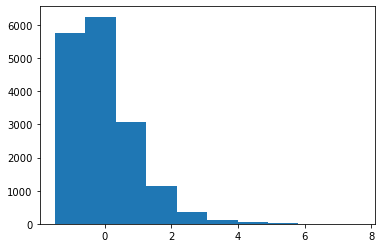

In [221]:
# QC to make sure I did the right axis for normalization
plt.hist(df['AAAA'])
df['AAAA'].describe()

## Perform PCA 

In [236]:
pca = PCA(n_components=15)
pca.fit(df.loc[:,non_obj_columns].values.T)
PCAdata = pca.components_.T
PCAdata.shape

(16809, 15)

<BarContainer object of 15 artists>

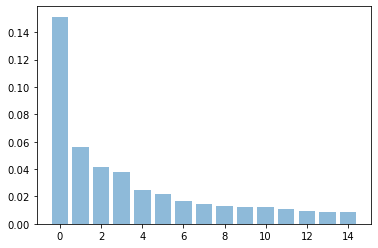

In [237]:
exp_var_pca = pca.explained_variance_ratio_
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')

## Perform tSNE on PCA components
In theory we should mess with the `perplexity` but I'm lazy and wont be doing that yet.

In [238]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [239]:
z = tsne.fit_transform(PCAdata)

/home/mkozubov/miniconda3/envs/stats/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mkozubov/miniconda3/envs/stats/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16809 samples in 0.031s...
[t-SNE] Computed neighbors for 16809 samples in 7.997s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16809
[t-SNE] Computed conditional probabilities for sample 2000 / 16809
[t-SNE] Computed conditional probabilities for sample 3000 / 16809
[t-SNE] Computed conditional probabilities for sample 4000 / 16809
[t-SNE] Computed conditional probabilities for sample 5000 / 16809
[t-SNE] Computed conditional probabilities for sample 6000 / 16809
[t-SNE] Computed conditional probabilities for sample 7000 / 16809
[t-SNE] Computed conditional probabilities for sample 8000 / 16809
[t-SNE] Computed conditional probabilities for sample 9000 / 16809
[t-SNE] Computed conditional probabilities for sample 10000 / 16809
[t-SNE] Computed conditional probabilities for sample 11000 / 16809
[t-SNE] Computed conditional probabilities for sample 12000 / 16809
[t-SNE] Computed conditional probabilities for sam

## Use kmeans clustering to find patterns
There are ways to see what the optimal number of clusters is, but here I'm going by eye.

In [240]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(PCAdata)
set(kmeans.labels_)

{0, 1, 2, 3, 4}

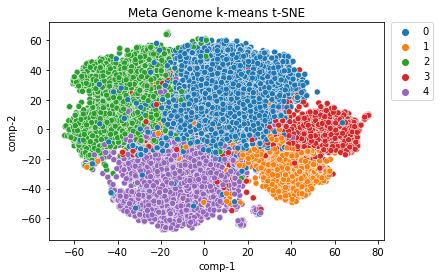

In [244]:
dfSNE = pd.DataFrame()
dfSNE['color'] = kmeans.labels_
dfSNE["comp-1"] = z[:,0]
dfSNE["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", 
                hue='color', palette="tab10",
                       data=dfSNE).set(title="Meta Genome k-means t-SNE")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [245]:
df.loc[df.origin.str.contains("Vibrio aerogenes"), 'origin'] = 'Vibrio aerogenes'
df.loc[df.origin.str.contains("Vibrio cholerae"), 'origin'] = "Vibrio cholerae"

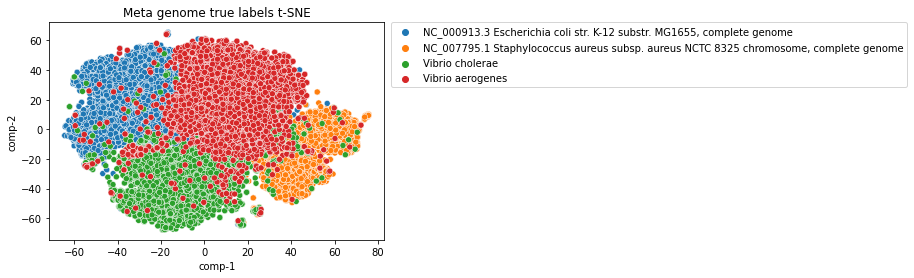

In [246]:
dfSNE = pd.DataFrame()
dfSNE['color'] = df['origin']
dfSNE["comp-1"] = z[:,0]
dfSNE["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", 
                hue='color', palette="tab10",
                       data=dfSNE).set(title="Meta genome true labels t-SNE")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Text(0.5, 1.0, 'Colorful Genome Reference')

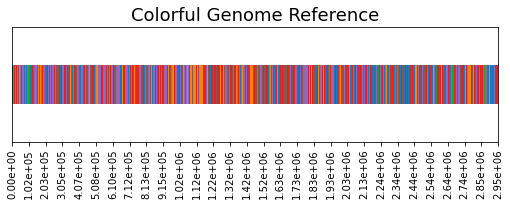

In [113]:
##############
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Colorful Genome Panel
##############
chunkSize = 1000
figureHeight = 5
figureWidth = 8
palette = sns.color_palette("tab10")[:len(set(dfSNE.color))]


genomePanelHeight = 2 ; relativegenomePanelHeight = genomePanelHeight/figureHeight
genomePanelWidth = 9 ; relativegenomePanelWidth = genomePanelWidth/figureWidth

genomePanel = plt.axes([0.05, 0.5,relativegenomePanelWidth,relativegenomePanelHeight])
genomePanel.tick_params(bottom=True, labelbottom=True,
    left=False, labelleft=False,
    right=False, labelright=False,
    top=False, labeltop=False)

n_chunk = dfSNE.shape[0]
for i in range(0,n_chunk):
    left = i*chunkSize
    rectangleHeight = 1
    rectangleWidth = chunkSize
    color = palette[dfSNE['color'].iloc[i]]
    rectangle=mplpatches.Rectangle([left,1],
                                   rectangleWidth,
                                   rectangleHeight,
                                   facecolor=color,
                                   edgecolor='black',
                                   linewidth=0)
    genomePanel.add_patch(rectangle)

genomePanel.set_ylim([0,3])
genomePanel.set_xlim([0,chunkSize*n_chunk])

xmin = 0
xmax = chunkSize*n_chunk
genomePanel.set_xticks([x for x in np.linspace(xmin,xmax,30)])
genomePanel.set_xticklabels(["{:.2e}".format( round(x,0) ) for x in np.linspace(xmin,xmax,30)], rotation=90)
genomePanel.set_title('Colorful Genome Reference', fontdict={'fontsize':18})

##############

In [93]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Conclusion
It appears that orange is consistently labelled rRNA. 

The large red near 1.36e6 is "hyperosmolarity resistance protein Ebh", a large multispecies protein that confers resistance against Complement cascade. Interesting that it is read as being rather different from the rest of Staph.

The other little island of red to the right of the genome is probably "LPXTG-anchored DUF1542 repeat protein FmtB" which seems to be yet another surface protein. This one seems important for biofilm formation, so maybe it is possible that it is another immune evading protein. Maybe that is what red is: immune evasion. More research would be needed to conclude anything like that.

It is very interesting that the genome seems segregated into two regions, up and downstream.